In [1]:
import cv2
import numpy as np
import os
import pandas as ps
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch import optim
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
# This is for the progress bar.
from tqdm.auto import tqdm
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
#文件夹位置加载
train_folder_path = '../data/FAZ/Domain1/train/imgs'
mask_folder_path = '../data/FAZ/Domain1/train/mask'
test_folder_path='../data/FAZ/Domain1/test/imgs'
train_files = os.listdir(train_folder_path)
mask_files= os.listdir(mask_folder_path)
for i in range(244):
    if(mask_files[i]==train_files[i]):
        pass
    else:
        print(mask_files[i],train_files[i],i)
        del train_files[i]
        break
# test_files = os.listdir(test_folder_path)
print(len(train_files),len(mask_files))

102_D_94.png .ipynb_checkpoints 141
244 244


In [3]:
# 定义数据集

# 转化为tensor
transform=transforms.Compose([
    transforms.ToTensor()
])
class MyDataset(Dataset):

    def __init__(self,train_files = None,test_files = None):
        super(MyDataset).__init__()
        self.train_files =train_files
        if train_files != None:
            self.train_files = train_files
        self.test_files =test_files
        if test_files != None:
            self.test_files = test_files
        print(f"One sample",self.train_files[0])
    
    def __len__(self):
        return len(self.train_files)

    # cv读取图像信息
    def __getitem__(self,idx):
        
        fname = self.train_files[idx]
        im = cv2.imread(os.path.join(train_folder_path,fname))
        #im = self.data[idx]
        mname = self.test_files[idx]
        segemnt_im = cv2.imread(os.path.join(mask_folder_path,mname))
        return transform(im),transform(segemnt_im)

In [4]:
#定义网络
""" Parts of the U-Net model """

class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)

# 下采样
class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)

# 上采样
class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,64)
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,3,3,1,1)
        self.Th=nn.Sigmoid()

    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))

        return self.Th(self.out(O4))

x=torch.randn(2,3,256,256)
net=UNet()
print(net(x).shape) 

torch.Size([2, 3, 256, 256])


In [5]:
dataset = MyDataset(train_files=train_files,test_files=mask_files)

One sample 057_N_60.png


## loss 函数

In [6]:
def dice_loss(y_pred, y_real):
    eps = 1e-8
    y_pred = torch.sigmoid(y_pred)
    
    num = torch.sum(2*y_real*y_pred)
    den = torch.sum(y_real + y_pred)
    
    return 1-1/(256*256)*(num+eps)/(den+eps)
    
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    #y_pred =  # hint: torch.clamp
    L = (y_pred.clamp(min=0) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()
    focal_loss = 1*(1-torch.exp(-L))**gamma * L
    return focal_loss


### Tarin

not successful load weight
0-0-train_loss===>>0.6511476635932922
0-10-train_loss===>>0.1412591189146042
0-20-train_loss===>>0.07226958125829697
0-30-train_loss===>>0.05397291108965874
1-0-train_loss===>>0.059064723551273346
1-10-train_loss===>>0.06323663890361786
1-20-train_loss===>>0.037667166441679
1-30-train_loss===>>0.041193507611751556
2-0-train_loss===>>0.06496740877628326
2-10-train_loss===>>0.05773475021123886
2-20-train_loss===>>0.07724453508853912
2-30-train_loss===>>0.03169950470328331
3-0-train_loss===>>0.05819873511791229
3-10-train_loss===>>0.04984600469470024
3-20-train_loss===>>0.055752985179424286
3-30-train_loss===>>0.04889967665076256
4-0-train_loss===>>0.03509267419576645
4-10-train_loss===>>0.0689769983291626
4-20-train_loss===>>0.031881146132946014
4-30-train_loss===>>0.028308790177106857
5-0-train_loss===>>0.033066846430301666
5-10-train_loss===>>0.03825889155268669
5-20-train_loss===>>0.02754279598593712
5-30-train_loss===>>0.02492855116724968
6-0-train_loss===>

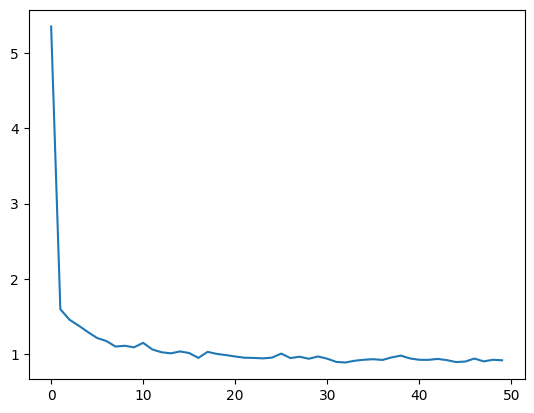

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path='params/unet.pth'
data_path=r'data'
save_path='train_image'

data_loader=DataLoader(dataset,batch_size=8,shuffle=True)
net=UNet().to(device)
if os.path.exists(weight_path):
    net.load_state_dict(torch.load(weight_path))
    print('successful load weight！')
else:
    print('not successful load weight')

opt=optim.Adam(net.parameters())
loss_fun=nn.BCELoss()
epoch=50
lossArr =[]
for j in range(epoch):
    lossItem = 0
    for i,(image,segment_image) in enumerate(data_loader):
            image, segment_image=image.to(device),segment_image.to(device)

            out_image=net(image)
            train_loss=loss_fun(out_image,segment_image)

            opt.zero_grad()
            train_loss.backward()
            opt.step()
            lossItem = lossItem + train_loss.item()
            if i%10==0:
                print(f'{j}-{i}-train_loss===>>{train_loss.item()}')
            
            if i%50==0:
                torch.save(net.state_dict(),weight_path)
            
            # 组合图片
            _image=image[0]
            _segment_image=segment_image[0]
            _out_image=out_image[0]

            img=torch.stack([_image,_segment_image,_out_image],dim=0)
            save_image(img,f'{save_path}/{i}.png')
    lossArr.append(lossItem)
x =range(epoch)
plt.figure()
plt.plot(x, lossArr)
plt.show()

In [8]:
net=UNet().to('cuda')
weights='params/unet.pth'
if os.path.exists(weights):
    net.load_state_dict(torch.load(weights))
    print('successfully')
else:
    print('no loading')
net.eval()


test_file = os.listdir(test_folder_path)
file = test_file[0]
print(file)



img=cv2.imread(os.path.join(test_folder_path,file))
img_data=transform(img).cuda()
    
out=net(img_data)
save_image(img_data[0],f'{result}/{i}.png')
# cv2.imshow('out',out*255.0)
# cv2.waitKey(0)
'''
for file,index in test_files:
    img=cv.imread(file)
    img_data=transform(img).cuda()
    img_data=torch.unsqueeze(img_data,dim=0)
    
    out=net(img_data)
    out=torch.argmax(out,dim=1)
    out=torch.squeeze(out,dim=0)
    out=out.unsqueeze(dim=0)
    print(set((out).reshape(-1).tolist()))
    out=(out).permute((1,2,0)).cpu().detach().numpy()
    cv2.imwrite(f'result/result{index}.png',out)
    cv2.imshow('out',out*255.0)
    cv2.waitKey(0)

'''

successfully
024_N_30.png


ValueError: expected 4D input (got 3D input)